In [4]:
from .__init__ import rgb_to_hsv

ModuleNotFoundError: No module named '__main__.__init__'; '__main__' is not a package

In [5]:
def hsv_to_rgb(h, s, v):
    if s == 0.0:
        return v, v, v
    i = int(h*6.0) # XXX assume int() truncates!
    f = (h*6.0) - i
    p = v*(1.0 - s)
    q = v*(1.0 - s*f)
    t = v*(1.0 - s*(1.0-f))
    i = i%6
    if i == 0:
        return v, t, p
    if i == 1:
        return q, v, p
    if i == 2:
        return p, v, t
    if i == 3:
        return p, q, v
    if i == 4:
        return t, p, v
    if i == 5:
        return v, p, q
    # Cannot get here

In [7]:
hsv_to_rgb(1,1,255)

(255, 0.0, 0.0)

In [4]:
### 
symbol_vect = \
[ 0,
 1, 1,
  0,
 1, 1,
   1]



sum([ (2**i) * v for i,v in enumerate(symbol_vect)])

62

In [38]:
21+-7

14

In [30]:
# REV:
source_order = [ 0,
 1, 2,
  3,
 4, 5,
   6]

In [31]:
target_order = [ 5,
 6, 4,
  3,
 2, 0,
   1]

In [32]:
dict(zip(source_order, target_order))

{0: 5, 1: 6, 2: 4, 3: 3, 4: 2, 5: 0, 6: 1}

In [33]:
#FWD
target_order = [ 1,
 2, 0,
  3,
 6, 4,
   5]
dict(zip(source_order, target_order))

{0: 1, 1: 2, 2: 0, 3: 3, 4: 6, 5: 4, 6: 5}

In [43]:
# Small symbol...

target_order = [ 1, 0,2,3, 4,6,5]
                
dict(zip(source_order,[i for i in target_order]))

{0: 1, 1: 0, 2: 2, 3: 3, 4: 4, 5: 6, 6: 5}

In [ ]:
# last small symbol
target_order = [ 16, 15,17,18, 19,21,20]
                
dict(zip(source_order,[i-15 for i in target_order]))

In [9]:
CHAR_DICT = {0: 119,
 ' ': 0,
 1: 36,
 2: 93,
 3: 109,
 4: 46,
 5: 107,
 6: 123,
 7: 37,
 8: 127,
 9: 111,
 'A': 63,
 'B': 127,
 'C': 83}

In [8]:
def get_character_vect(char):
    return  [ (CHAR_DICT[char]  >> i) & 1 for i in range(7) ]

In [10]:
get_character_vect(1)

[0, 0, 1, 0, 0, 1, 0]

In [171]:
response[:2]==bytearray([255,134])

True

In [ ]:
buffer = [ 255, 1, command]+data+[0]
# Set checksum:
buffer[-1] = 255-(sum(buffer)%256)
cmd = bytes(buffer)
if uart is None:

In [ ]:
from machine import UART
uart_mhz = UART(2, tx=17, rx=16)
uart_mhz.init(9600)
uart_sds =  UART(1, tx=32, rx=33)
uart_sds.init(9600)

In [173]:
from ucollections import namedtuple 
mh_data = namedtuple('MH Z19', ('CO2_PPM','Temp_C','Status','DeltaABC'))

def mhz_write_command(uart, command=134, data=[0]*5):
    buffer = [ 255, 1, command] + data + [0] # Construct command
    buffer[-1] = 255-(sum(buffer)%256) # Set checksum
    uart.write(bytes(buffer)) # Send command to sensor
    while uart.any()<9 : pass # Wait for response
    response = uart.read(9)
    if 255-sum(response[:-1])%256!=response[-1]: # Check response checksum
        raise ValueError('Invalid CHK')
    if bytearray([255,command])!=response[:2]: # Check response header (first two bytes)
        raise ValueError('Invalid header')
    return response

def mhz_get_measurement(uart):
    response = write_command(uart)
    return mh_data(
        response[2]*256 + response[3], # CO2
        response[4]-40, # Temp
        response[5], # Status
        response[6]*256 + response[7], #Uh,Ul
    )





In [203]:
from collections import namedtuple

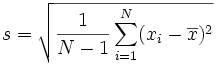

In [215]:
from math import sqrt

def mean_and_var(data):
    mean = sum(data) / len(data)
    return mean,  sum((i - mean) ** 2 for i in data) / (len(data)-1)

sds_data = namedtuple('SDS_data', ('P2d5_PPM','P10_PPM'))
sds_data_inc_var = namedtuple('SDS_data', ('P2d5_PPM','P10_PPM','P2d5_std_PPM','P10_std_PPM'))

def sds_write_command(uart, command=4, data=[0]*12):
    uart.read()
    buffer = [170, 180, command] + data + [255,255, 0 , 171] # Construct command (12 byte)
    buffer[-2] = (command+sum(data)-2)%256  # Set checksum
    uart.write(bytes(buffer)) # Send command to sensor
    while uart.any()<10 : pass # Wait for response
    response = uart.read(10)
    if sum(response[2:8])%256!=response[-2]: # Check response checksum
        raise ValueError('Invalid CHK')
    if response[0]!=170 or response[-1]!=171: # Check response header (first byte)
        raise ValueError('Invalid header')
    return response


def sds_burst(uart, n_samples=10):
    # Wake:
    sds_write_command(uart, command=6,  data=[1, 1]+[0]*10)
    #Wait
    utime.sleep(2)
    # gather
    P2d5_data, P10_data = [], []
    for i in range(n_samples):
        r = sds_get_single_measurement(uart)
        P2d5_data.append(r.P2d5_PPM)
        P10_data.append(r.P10_PPM)
        utime.sleep(1)
        
    P2d5, P2d5_var =  mean_and_var(P2d5_data)
    P10, P10_var =  mean_and_var(P10_data)
    # end
    sds_write_command(uart, command=6,  data=[1, 0]+[0]*10)
    return sds_data_inc_var( P2d5,P10, sqrt(P2d5_var), sqrt(P10_var) )

def sds_get_single_measurement(uart):
    response = sds_write_command(uart)
    return sds_data(
        response[3]*256 + response[2]/10, # PM 2.5
        response[5]*256 + response[4]/10, # PM 10
    )


In [222]:
response = b'\xaa\xc0\x08\x00\x1f\x00\x8cp#\xab'


0.8

In [235]:
is_set(2,0)

False

In [237]:

while True:
    start= utime.ticks_us()
    for i,byte in enumerate(to_send):

        for ib,bit in enumerate(bits(byte)):

            if bit:
                output_pin.on()
            else:
                output_pin.off()

            # Leave the bit in its state for a while:
            end_time = utime.ticks_add( start, i*clock_time_us*8+clock_time_us*ib)
            while utime.ticks_diff(end_time, utime.ticks_us())>=0:
                
                pass

                
                
    output_pin.off()
    utime.sleep_ms(40)

170

In [253]:

len([i*clock_time_us*8+clock_time_us*ib for i in range(3) for ib in range(8)])

24

In [263]:
import struct
q = bytearray(struct.pack("f", -0.1))
msg = [int(i) for i in q]

34

In [233]:
from machine import Pin
import utime

def is_set(x, n):
    # a more bitwise- and performance-friendly version:
    return x & 1 << n != 0

def bits(byte):
    for i in range(8):
        yield is_set(byte, i)
        
output_pin = Pin(14,Pin.OUT)


def send_int_list(to_send,clock_time_us=5000):
        
    for i,byte in enumerate(to_send):
        
        for ib,bit in enumerate(bits(byte)):
            if bit:
                output_pin.on()
                last=True
            else:
                output_pin.off()
                last=False
            utime.sleep_us(clock_time_us)
            
                
                
    output_pin.off()
    utime.sleep_ms(100)


def send_data(device_id, value, clock_time_us=5000): # Every value is 4 words (float)
    
    q = bytearray(struct.pack("f", value))
    msg = [device_id+1] + [int(i) for i in q]
    chk = sum(msg)%256
    
    send_int_list(msg+[chk], clock_time_us=clock_time_us)
    



ModuleNotFoundError: No module named 'machine'

1.539989614439558e-36

In [ ]:
# timing test
now = utime.ticks_us()
utime.sleep_ms(40)
utime.ticks_diff( utime.ticks_us(), now)

In [244]:
# Slave:
from machine import I2C
from machine import Pin
import utime
import ustruct as struct
input_pin = Pin(14,Pin.IN)
        
def read_bytes(init_time, pin, n, spacing_us=5000):
    msg = []
    for byte_pos in range(n):
        byte = []
        for bit in range(8):
            # Wait for center bit alignment:
            if byte_pos==0 and bit==0:
                byte.append(pin.value())
                continue

            center_pos = int(bit*spacing_us + spacing_us*0.1 + byte_pos*spacing_us*8)
            end_time = utime.ticks_add( init_time, center_pos)
            while utime.ticks_diff(end_time, utime.ticks_us())>=0:
                pass

            # Read bit value:
            byte.append(pin.value())
        msg.append(byte)
    return msg
        

def get_msg(spacing_us=10000, n=10):
     # Decode incoming message
    zero_start=None
    one_start = None
    while True:
        
        if input_pin.value()==0:
            if zero_start is None:
                zero_start = utime.ticks_us()
        else:
            if zero_start is not None:
                one_start = utime.ticks_us()
                dtime =  utime.ticks_diff( one_start, zero_start)

                
                #if dtime>20:
                #    print(dtime)
                
                if dtime>=38000:
                    
                    break
                
                zero_start=None
    
    msg = read_bytes(one_start, input_pin, n=n, spacing_us=spacing_us)
    return msg
    
    
while True:
    msg = get_msg(5300, n=6)
    int_v = [ sum([2**i*v for i,v in enumerate(byte)]) for byte in msg]
    print(int_v)
    f = struct.unpack('f',bytearray(int_v[1:5]))
    print( int_v[0], f )


ModuleNotFoundError: No module named 'machine'

3

In [ ]:
# Slave:
from machine import I2C
from machine import Pin
import utime

input_pin = Pin(14,Pin.IN)

def read_byte(init_time, pin, byte_pos=0, spacing_us=10000):
    
    byte = []
    for bit in range(8):
        # Wait for center bit alignment:
        if byte_pos==0 and bit==0:
            byte.append(pin.value())
            continue
        
        center_pos = int(bit*spacing_us + spacing_us*0.1 + byte_pos*spacing_us*8)
        end_time = utime.ticks_add( init_time, center_pos)
        while utime.ticks_diff(end_time, utime.ticks_us())>=0:
            pass
        
        
        # Read bit value:
        byte.append(pin.value())
    
    return byte
        
        
def read_bytes(init_time, pin, n, spacing_us=10000):
    msg = []
    for byte_pos in range(n):
        byte = []
        for bit in range(8):
            # Wait for center bit alignment:
            if byte_pos==0 and bit==0:
                byte.append(pin.value())
                continue

            center_pos = int(bit*spacing_us + spacing_us*0.1 + byte_pos*spacing_us*8)
            end_time = utime.ticks_add( init_time, center_pos)
            while utime.ticks_diff(end_time, utime.ticks_us())>=0:
                pass


            # Read bit value:
            byte.append(pin.value())
        msg.append(byte)
    return msg
        
        
while True:
    
    # Decode incoming message
    zero_start=None
    one_start = None
    while True:
        
        if input_pin.value()==0:
            if zero_start is None:
                zero_start = utime.ticks_us()
        else:
            if zero_start is not None:
                one_start = utime.ticks_us()
                dtime =  utime.ticks_diff( one_start, zero_start)

                
                #if dtime>20:
                #    print(dtime)
                
                if dtime>=38000:
                    
                    break
                
                zero_start=None

    # Get current timing

    #first_byte = read_byte(one_start, input_pin)
    #second_byte = read_byte(one_start, input_pin, 1)
    #third_byte = read_byte(one_start, input_pin, 2)
    msg = read_bytes(one_start, input_pin, 4)
    
    if sum(msg[0])!=8: # We are not at the start...
        print('Not aligned')
        
    print(msg)

In [210]:
a,b= 0,0
r = 1,2

a,b = a+r[0],b+r[1]

In [172]:
The number of bytesNameContent0
Message headerAA1Commander No.C02DATA 1PM2.5 Low byte3DATA 2PM2.5 High byte4DATA 3PM10 Low byte5DATA 4PM10 High byte6DATA 5ID byte 17DATA 6ID byte 28Check-sumCheck-sum9Message tailABCheck-sum: Check-sum=DATA1+DATA2+...+DATA6 。

KeyboardInterrupt: 

In [185]:
len([ int(i) for i in b'\xaa\xb4\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\x02\xab'])

19

In [199]:
response = b"\xaa\xc0\x08\x00#\x00\x8cp'\xab"



224.0

In [151]:
bytes(buffer)==b'\xff\x01\x86\x00\x00\x00\x00\x00\x79'

True

In [150]:
len(b'\xff\x01\x86\x00\x00\x00\x00\x00\x79' )

9

In [137]:
b'\xff\x01\x86\x00\x00\x00\x00\x00\x00y'
b'\xff\x01\x86\x00\x00\x00\x00\x00\x79'

b'0x79'

In [141]:
bytes([121,122])

b'yz'

In [126]:
bytes([121,121,0])

b'yy\x00'

In [58]:
[b'\xFF',b'\x01', command]

[b'\xff', b'\x01', b'\x86']

In [201]:
ord(b'\x01')

1